In [1]:
import geocube
import rioxarray 
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

# Create Population Map

In [2]:
### Process GPW data

country_pop = pd.read_csv(r"C:\Working Papers\Paper - Child Mortality and Climate Shocks\Data\Data_in\UN Population Estimates\unpopulation_dataportal_20250902202059.csv")
country_pop.loc[country_pop.IndicatorId == 49,"Indicator"] = "Total Population"
country_pop.loc[country_pop.IndicatorId == 47,"Indicator"] = "Total Births"

country_pop = country_pop[["Indicator", "LocationId", "Location", "Iso3", 'Time', 'Value']]
country_pop = country_pop.pivot(index=["LocationId","Location","Iso3","Time"], columns="Indicator").reset_index()
country_pop.columns = ['_'.join(col).replace('_', '') for col in country_pop.columns.values]
country_pop["born_ratio"] = country_pop["ValueTotal Births"]  / country_pop["ValueTotal Population"]  

gpw_years = np.array([2000, 2005, 2010, 2015, 2020])
country_pop['year_gpw'] = country_pop['Time'].apply(lambda y: gpw_years[np.abs(gpw_years - y).argmin()])
country_pop = country_pop.groupby(by=['LocationId','Iso3','year_gpw']).born_ratio.mean().reset_index()

In [3]:
### Process GPW data

# GPW map with IDs
gpw_country_ids = gpd.read_file(r"E:\Datasets\Gridded Population of the World\15-minutes\gpw_v4_national_identifier_grid_rev11_15_min.shp")
gpw_country_ids = gpw_country_ids[['Value', 'ISOCODE', 'NAME0', 'MEANUNITKM', 'geometry']]
whole_world = gpw_country_ids[["geometry"]].dissolve()

# Add born_ratio to gpw_country_ids
gpw_country_ids = gpw_country_ids.merge(country_pop, left_on="Value", right_on="LocationId", validate="1:m", how="inner")

# Keep only the ones that are in DHS
dhs = pd.read_stata(r"C:\Working Papers\Paper - Child Mortality and Climate Shocks\Data\Data_in\DHS\DHSBirthsGlobalAnalysis_07272025.dta")
dhs_iso = dhs.code_iso3.unique().tolist()
gpw_country_ids = gpw_country_ids[gpw_country_ids.ISOCODE.isin(dhs_iso)]
print(f"Number of countries: {gpw_country_ids.ISOCODE.unique()}")

# Clean columns
gpw_country_ids = gpw_country_ids[["geometry", "year_gpw", "born_ratio"]].rename(columns={"year_gpw":"time"})

Number of countries: ['ALB' 'AGO' 'BGD' 'ARM' 'BOL' 'MMR' 'BDI' 'KHM' 'CMR' 'CAF' 'TCD' 'COL'
 'COM' 'COD' 'BEN' 'DOM' 'ETH' 'GAB' 'GMB' 'GHA' 'GTM' 'GIN' 'GUY' 'HTI'
 'HND' 'IND' 'CIV' 'JOR' 'KEN' 'KGZ' 'LSO' 'LBR' 'MDG' 'MWI' 'MLI' 'MRT'
 'MDA' 'MAR' 'MOZ' 'NAM' 'NIC' 'NGA' 'PAK' 'PER' 'PHL' 'TLS' 'RWA' 'SEN'
 'SLE' 'ZAF' 'ZWE' 'SWZ' 'TJK' 'TGO' 'UGA' 'EGY' 'TZA' 'BFA' 'ZMB']


In [4]:
### Gridded Population of the World
gpw_tifs_paths = [
    r"e:\Datasets\Gridded Population of the World\15-minutes\gpw_v4_population_count_adjusted_to_2015_unwpp_country_totals_rev11_2020_15_min.tif", 
    r"e:\Datasets\Gridded Population of the World\15-minutes\gpw_v4_population_count_adjusted_to_2015_unwpp_country_totals_rev11_2000_15_min.tif", 
    r"e:\Datasets\Gridded Population of the World\15-minutes\gpw_v4_population_count_adjusted_to_2015_unwpp_country_totals_rev11_2005_15_min.tif", 
    r"e:\Datasets\Gridded Population of the World\15-minutes\gpw_v4_population_count_adjusted_to_2015_unwpp_country_totals_rev11_2010_15_min.tif", 
    r"e:\Datasets\Gridded Population of the World\15-minutes\gpw_v4_population_count_adjusted_to_2015_unwpp_country_totals_rev11_2015_15_min.tif",
]
gpw_tifs_paths.sort()

tifs = []

for tif_path in gpw_tifs_paths:

    # Load and clean tif
    tif = rioxarray.open_rasterio(tif_path)
    tif = tif.sel(band=1).drop_vars(["band", "spatial_ref"])
    
    # Add year
    tif_year = tif_path.replace("_15_min.tif", "")[-4:]
    tif = tif.expand_dims(time=[int(tif_year)]) 
    tif.name = "total_population"
    tifs += [tif]

pop_dataset = xr.concat(tifs, dim="time").to_dataset()
pop_dataset["total_population"] = pop_dataset.total_population.where(pop_dataset["total_population"]>0, np.nan)
pop_dataset = pop_dataset.rio.write_crs("EPSG:4326")

In [5]:
from geocube.api.core import make_geocube

grid_ds_years = []
for year in gpw_country_ids.time.unique():
    country_grid_ds_year = make_geocube(
        vector_data=gpw_country_ids[gpw_country_ids.time == year],
        measurements=['born_ratio'], # The column to burn into the raster
        like=pop_dataset,          # Use this raster as a template for the output grid
        fill=np.nan                     # The "no data" value for cells without a polygon
    )
    country_grid_ds_year = country_grid_ds_year.expand_dims(time=[int(year)]) 
    
    grid_ds_years += [country_grid_ds_year]


# # Extract the DataArray from the Dataset
# country_grid = country_grid_ds['country_id']
ratio_dataset = xr.concat(grid_ds_years, dim="time")

In [6]:
## Create a single dataset with both variables
dataset = xr.combine_by_coords([pop_dataset, ratio_dataset])
dataset["total_population"] = dataset["total_population"].where(dataset["born_ratio"].notnull(), np.nan)

C:\Users\abbat\AppData\Local\Temp\ipykernel_6796\2466988600.py:2: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  dataset = xr.combine_by_coords([pop_dataset, ratio_dataset])


# Create Climate map

In [ ]:
# --- 1. Load the datset ---

climate_ds = xr.open_dataset(r"C:\Working Papers\Paper - Child Mortality and Climate Shocks\Data\Data_out\Climate_shocks_v11.nc")
climate_ds = climate_ds.sel(time=slice("01-01-1999","12-31-2020"))
climate_ds = climate_ds[["stdm_t"]]

climate_ds_6m = climate_ds.rolling(time=6, center=False).mean()
climate_ds_9m = climate_ds.rolling(time=9, center=False).mean()
climate_ds_6m ["stdm_t_pos_6m"] = climate_ds_6m .stdm_t.where((climate_ds_6m .stdm_t > 0) | (climate_ds_6m .stdm_t.isnull()), 0)
climate_ds_6m ["stdm_t_neg_6m"] = climate_ds_6m .stdm_t.where((climate_ds_6m .stdm_t < 0) | (climate_ds_6m .stdm_t.isnull()), 0)
climate_ds_9m ["stdm_t_pos_9m"] = climate_ds_9m .stdm_t.where((climate_ds_9m .stdm_t > 0) | (climate_ds_9m .stdm_t.isnull()), 0)
climate_ds_9m ["stdm_t_neg_9m"] = climate_ds_9m .stdm_t.where((climate_ds_9m .stdm_t < 0) | (climate_ds_9m .stdm_t.isnull()), 0)
climate_ds_6m = climate_ds_6m.drop_vars(["stdm_t"])
climate_ds_9m = climate_ds_9m.drop_vars(["stdm_t"])

climate_ds = xr.combine_by_coords([climate_ds_6m, climate_ds_9m]).rename_dims({"lat":"y", "lon":"x"}).rename_vars({"lat":"y", "lon":"x"})

In [8]:
# Make monthly so it matches the climate_ds structure
dataset["time"] = pd.to_datetime(dataset.time, format="%Y")
dataset = dataset.interp_like(climate_ds, method="linear", kwargs={"fill_value":"extrapolate"})
full_ds = xr.combine_by_coords([dataset, climate_ds])

In [9]:
high_temp_attributable_deaths_1year_iushocks = (1.5 + .4 + 1.1 + 0.6)
high_temp_attributable_deaths_1year_1yearshock = (1.1 + 0.6)
low_temp_attributable_deaths_1year_iushocks = (1.7 + 0.7 + 0.6)
low_temp_attributable_deaths_1year_1yearshock = (1.2 + 0.5 + 0.6)

print(f"High Temp Attributable Deaths in the first year (in utero shocks): {high_temp_attributable_deaths_1year_iushocks}")
print(f"Low Temp Attributable Deaths in the first year (in utero shocks): {low_temp_attributable_deaths_1year_iushocks}")
print(f"High Temp Attributable Deaths in the first year (1st year shocks): {high_temp_attributable_deaths_1year_1yearshock}")
print(f"Low Temp Attributable Deaths in the first year (1st year shocks): {low_temp_attributable_deaths_1year_1yearshock}")

full_ds["pos_deaths_per_1000_childs"] = (
    full_ds["stdm_t_pos_9m"] * high_temp_attributable_deaths_1year_iushocks + 
    full_ds["stdm_t_pos_6m"] * high_temp_attributable_deaths_1year_1yearshock 
)
full_ds["neg_deaths_per_1000_childs"] = (
    full_ds["stdm_t_neg_9m"] * -low_temp_attributable_deaths_1year_iushocks + 
    full_ds["stdm_t_neg_6m"] * -low_temp_attributable_deaths_1year_1yearshock 
)

full_ds["n_childs"] = full_ds["total_population"] * full_ds["born_ratio"]
full_ds["pos_deaths"] = full_ds["n_childs"] * full_ds["pos_deaths_per_1000_childs"] / 1000
full_ds["neg_deaths"] = full_ds["n_childs"] * full_ds["neg_deaths_per_1000_childs"] / 1000

full_ds["pos_deaths_per_1000_childs"] = full_ds["pos_deaths_per_1000_childs"].where(full_ds["pos_deaths"].notnull(), np.nan)
full_ds["neg_deaths_per_1000_childs"] = full_ds["neg_deaths_per_1000_childs"].where(full_ds["neg_deaths"].notnull(), np.nan)
full_ds["deaths_per_1000_childs"] = full_ds["pos_deaths_per_1000_childs"] + full_ds["neg_deaths_per_1000_childs"]

full_ds["total_deaths"] = full_ds["neg_deaths"] + full_ds["pos_deaths"]

High Temp Attributable Deaths in the first year (in utero shocks): 3.6
Low Temp Attributable Deaths in the first year (in utero shocks): 3.0
High Temp Attributable Deaths in the first year (1st year shocks): 1.7000000000000002
Low Temp Attributable Deaths in the first year (1st year shocks): 2.3


In [10]:
full_ds.total_deaths.sum()

<xarray.DataArray 'total_deaths' ()> Size: 8B
array(64738436.14446812)
Coordinates:
    spatial_ref  int64 8B 0

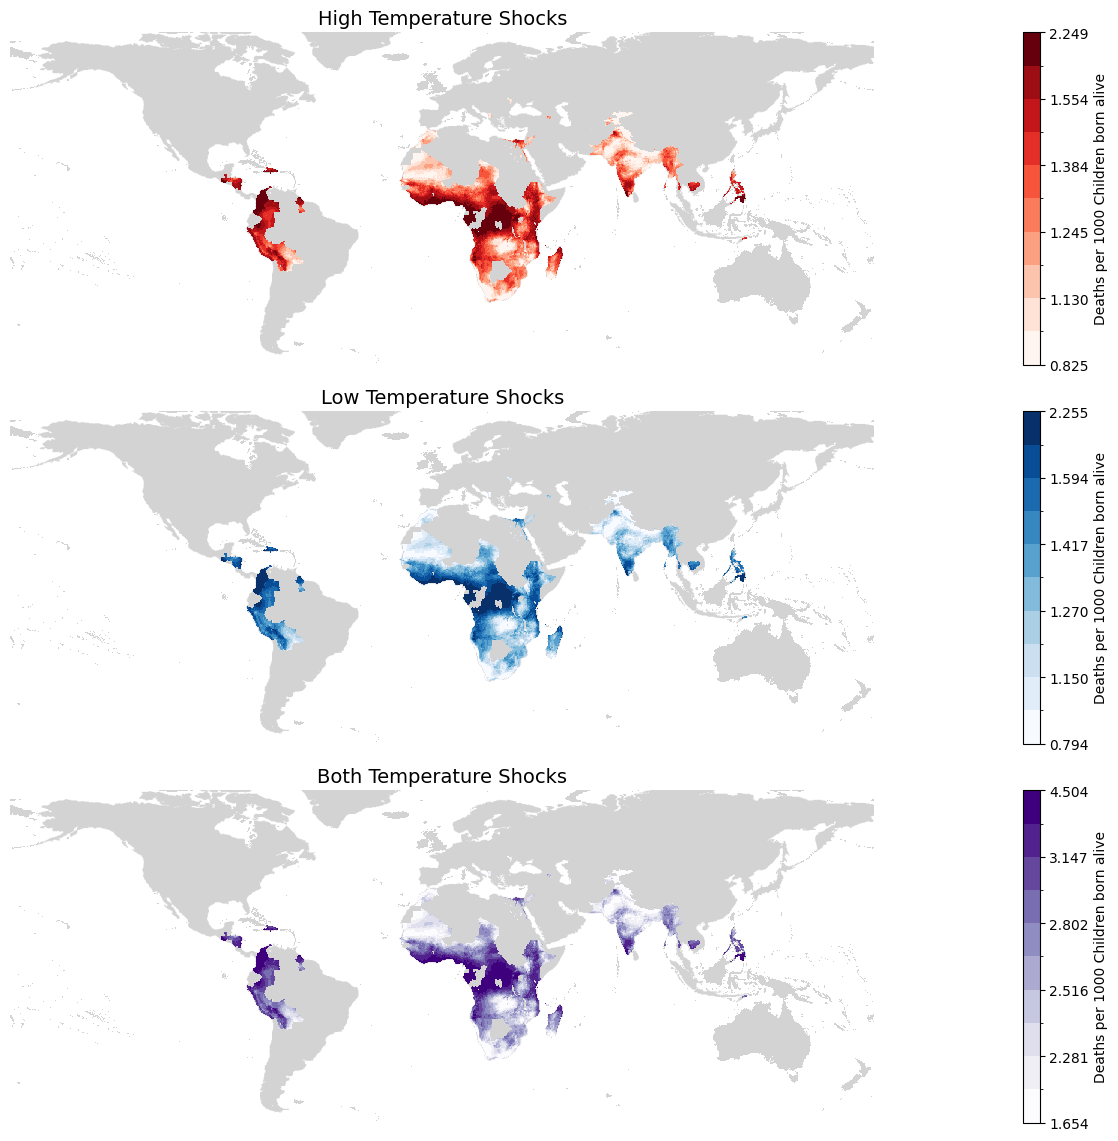

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# --- Main plotting code ---
fig, axs = plt.subplots(3, 1, figsize=(30, 12), sharex=True, sharey=True)
# fig.suptitle('Annual Climate Shock Deaths attributable to Temperature Anomalies', fontsize=16)

for ax in axs.flatten():
    whole_world.plot(color="lightgray", ax=ax)
    ax.set_axis_off()

# --- Plot 1: Positive Deaths per 1,000 children born ---
ax1 = axs[0]
pos_rel_deaths = full_ds["pos_deaths_per_1000_childs"].sel(y=slice(-60, 75)).mean(dim="time")

# Calculate the quintile breaks (20th, 40th, 60th, 80th percentiles)
quintile_breaks = np.nanpercentile(pos_rel_deaths, [10, 20, 30, 40, 50, 60, 70, 80, 90])
# Create the final list of levels for plotting, including the min and max
plot_levels = np.unique([pos_rel_deaths.min()] + list(quintile_breaks) + [pos_rel_deaths.max()])

# Plot with discrete levels
pos_rel_deaths.plot(
    ax=ax1,
    cmap='Reds',
    levels=plot_levels,
    cbar_kwargs={'label': 'Deaths per 1000 Children born alive'}
)
ax1.set_title("High Temperature Shocks", fontsize=14)


# --- Plot 2: Low Temperature Deaths per 1,000 children born ---
ax2 = axs[1]
neg_rel_deaths = full_ds["neg_deaths_per_1000_childs"].sel(y=slice(-60, 75)).mean(dim="time")
quintile_breaks = np.nanpercentile(neg_rel_deaths, [10, 20, 30, 40, 50, 60, 70, 80, 90])
plot_levels = np.unique([neg_rel_deaths.min()] + list(quintile_breaks) + [neg_rel_deaths.max()])
neg_rel_deaths.plot(
    ax=ax2,
    cmap='Blues',  # Using a different colormap for clarity
    levels=plot_levels,
    cbar_kwargs={'label': 'Deaths per 1000 Children born alive'}
)
ax2.set_title("Low Temperature Shocks", fontsize=14)

# --- Plot 3: Low Temperature Deaths per 1,000 children born ---
ax3 = axs[2]
neg_rel_deaths = full_ds["deaths_per_1000_childs"].sel(y=slice(-60, 75)).mean(dim="time")
quintile_breaks = np.nanpercentile(neg_rel_deaths, [10, 20, 30, 40, 50, 60, 70, 80, 90])
plot_levels = np.unique([neg_rel_deaths.min()] + list(quintile_breaks) + [neg_rel_deaths.max()])
neg_rel_deaths.plot(
    ax=ax3,
    cmap='Purples',  # Using a different colormap for clarity
    levels=plot_levels,
    cbar_kwargs={'label': 'Deaths per 1000 Children born alive'}
)
ax3.set_title("Both Temperature Shocks", fontsize=14)

# # --- Plot 3: Positive Total Deaths ---
# ax3 = axs[0][1]
# pos_deaths = full_ds["pos_deaths"].sel(y=slice(-60, 75)).mean(dim="time")
# quintile_breaks = np.nanpercentile(pos_deaths, [10, 20, 30, 40, 50, 60, 70, 80, 90])
# plot_levels = np.unique([pos_deaths.min()] + list(quintile_breaks) + [pos_deaths.max()])
# pos_deaths.plot(
#     ax=ax3,
#     cmap='Reds',
#     levels=plot_levels,
#     # cbar_kwargs={'label': 'Total Deaths'}
# )
# ax3.set_title("High Temperature Shocks - Total Deaths", fontsize=16)


# # --- Plot 4: Low Temperature Total Deaths ---
# ax4 = axs[1][1]
# neg_deaths = full_ds["neg_deaths"].sel(y=slice(-60, 75)).mean(dim="time")
# quintile_breaks = np.nanpercentile(neg_deaths, [10, 20, 30, 40, 50, 60, 70, 80, 90])
# plot_levels = np.unique([neg_deaths.min()] + list(quintile_breaks) + [neg_deaths.max()])
# neg_deaths.plot(
#     ax=ax4,
#     cmap='Blues', # Using a different colormap for clarity
#     levels=plot_levels,
#     # cbar_kwargs={'label': 'Total Deaths'}
# )
# ax4.set_title("Low Temperature Shocks - Total Deaths", fontsize=16)

# Adjust layout to prevent title overlap and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(r"C:\Working Papers\Paper - Child Mortality and Climate Shocks\Outputs\Figures\deaths_mapping.png", dpi=450, bbox_inches='tight')

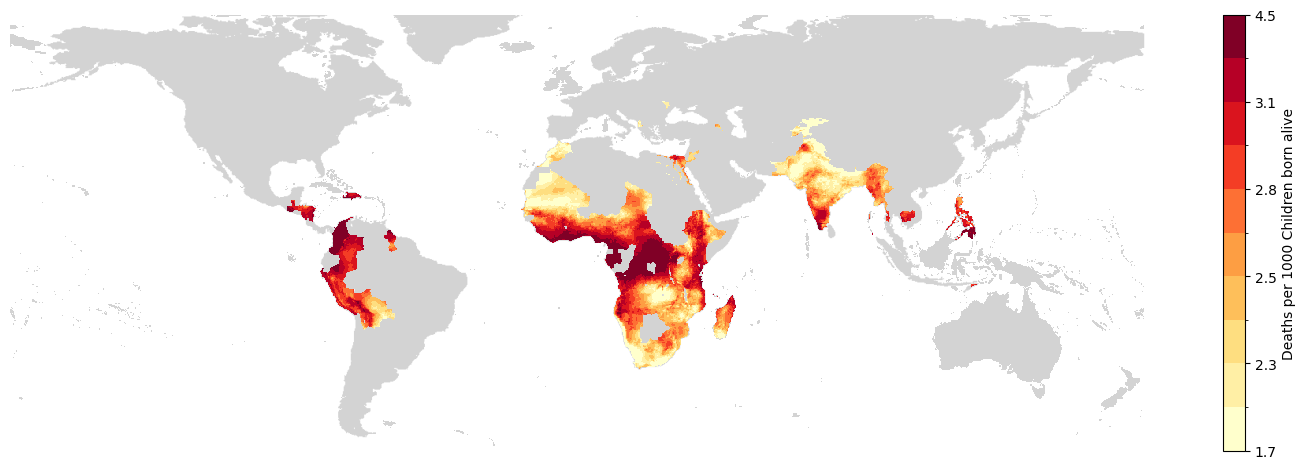

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# --- Main plotting code ---
fig, ax = plt.subplots(1, 1, figsize=(16, 5), sharex=True, sharey=True)
# fig.suptitle('Annual Climate Shock Deaths attributable to Temperature Anomalies', fontsize=16)

whole_world.plot(color="lightgray", ax=ax)
ax.set_axis_off()

# --- Plot 3: Low Temperature Deaths per 1,000 children born ---
ax3 = ax
neg_rel_deaths = full_ds["deaths_per_1000_childs"].sel(y=slice(-60, 75)).mean(dim="time")
quintile_breaks = np.nanpercentile(neg_rel_deaths, [10, 20, 30, 40, 50, 60, 70, 80, 90])
plot_levels = np.unique([neg_rel_deaths.min()] + list(quintile_breaks) + [neg_rel_deaths.max()])
neg_rel_deaths.plot(
    ax=ax3,
    cmap='YlOrRd',  # Using a different colormap for clarity
    levels=plot_levels,
    cbar_kwargs={
        'label': 'Deaths per 1000 Children born alive',
        'format': '%.1f',  # Add this line to format the color bar labels
}
)
ax3.set_title("", fontsize=14)

# Adjust layout to prevent title overlap and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(r"C:\Working Papers\Paper - Child Mortality and Climate Shocks\Outputs\Figures\deaths_mapping_both.png", dpi=450, bbox_inches='tight')

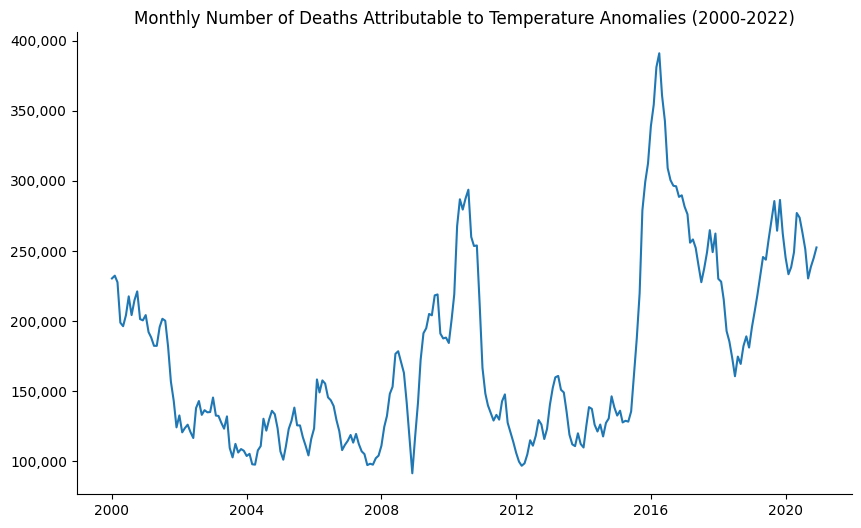

In [33]:
import seaborn as sns
import matplotlib

fig, ax = plt.subplots(1,1,figsize=(10,6) )
full_ds.total_deaths.sum(dim=["x", "y"]).sel(time=slice("2000-01-01",None)).plot(ax=ax)
from matplotlib.ticker import FuncFormatter
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("Monthly Number of Deaths Attributable to Temperature Anomalies (2000-2022)")
sns.despine()
plt.savefig(r"C:\Working Papers\Paper - Child Mortality and Climate Shocks\Outputs\Figures\deaths_over_time.png", dpi=450, bbox_inches='tight')

In [39]:
full_ds.total_deaths.sel(time=slice("2000-01-01",None)).sum(dim=["x", "y", "time"])

<xarray.DataArray 'total_deaths' ()> Size: 8B
array(44047034.08528203)
Coordinates:
    spatial_ref  int64 8B 0